### Data

In [1]:
%cd SOICTHackathon2024

[Errno 2] No such file or directory: 'SOICTHackathon2024'
/home/quangminh/Documents/code/Python/SOICTHackathon2024


In [2]:
import os 

In [5]:
train_folder = 'datasets/grayscale_train/train'
val_folder = 'datasets/grayscale_train/validation'

In [6]:
train_img_list = os.listdir(train_folder + '/images')

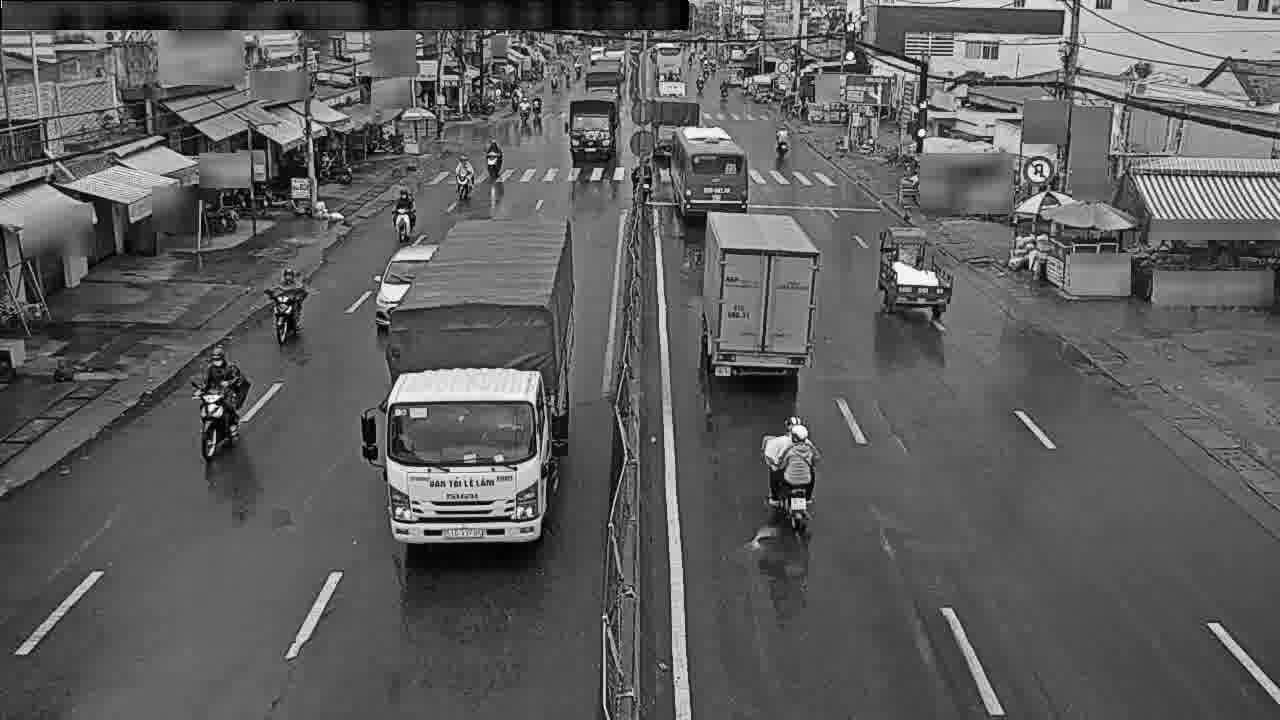

In [7]:
from PIL import Image
from IPython.display import display

im = Image.open(train_folder + '/images/' + train_img_list[25])
width, height = im.size
display(im)

In [8]:
print(width, height)

1280 720


In [ ]:
# !pip install albumentations

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import cv2
import torch


class CustomDataset(Dataset):
    def __init__(self, images_dir, labels_dir, img_size=640, mode='train'):
        """
        Custom dataset for YOLO.

        Args:
            images_dir (str): Directory with images.
            labels_dir (str): Directory with label files.
            img_size (int): Target image size (YOLO often expects square images).
            transform (callable, optional): Optional transform to apply to images.
        """

        self.img_size = img_size
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        if mode == 'train':
            self.transform = A.Compose([
                A.RandomCrop(width=640, height=640),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()  # Convert to PyTorch tensor
            ])

        else:
            self.transform = A.Compose([
                A.Resize(width=640, height=640),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()  # Convert to PyTorch tensor
            ])
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]
        

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Resize image to target size
        image = cv2.resize(image, (self.img_size, self.img_size))
        
        # Load label
        label_path = os.path.join(self.labels_dir, self.label_files[idx])

        # Convert image to tensor and normalize
        image = torch.from_numpy(image).float() / 255.0  # Normalize to [0,1]
        image = image.permute(2, 0, 1)  # Change to (C, H, W) format for PyTorch

        # Apply any data transformations
        if self.transform:
            image = self.transform(image)
        
        boxes = []
        with open(label_path, 'r') as f:
            for line in f.readlines():
                label = line.strip().split()
                # YOLO labels: [class, x_center, y_center, width, height]
                class_id = int(label[0])
                x_center, y_center, width, height = map(float, label[1:])
                boxes.append([class_id, x_center, y_center, width, height])

        return image, boxes


### Model

In [ ]:
%pip install -U ultralytics

Note: you may need to restart the kernel to use updated packages.


In [1]:
from ultralytics import YOLO, settings, RTDETR

In [2]:
print(settings)

JSONDict("/home/quangminh/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "288e0b2b0a213dec20ec52bec1e49eb19387b36ea96f2042338a72c0bcf1dedf",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": false,
  "wandb": false,
  "vscode_msg": true
}


In [3]:
# Update multiple settings
settings.update({"datasets_dir": "/home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets", 
                 "tensorboard": False, 
                 'wandb': False})

In [13]:
import os 
os.environ['WANDB_API_KEY'] = '0914f403b30196f64eb9744f9310b0029205c241'

In [ ]:
# check config
from ultralytics.cfg import get_cfg
config = get_cfg(overrides={
        'model': 'rtdetr-l.pt',
        'data': '/home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/grayscale_traindata.yaml',
        'imgsz': 640,
        'epochs': 20,
        'batch': 16,
        'device': 'cuda',
        'save_period': 5,
        'augment': True,
    })

config

In [9]:
# using trainer
from ultralytics.models.yolo.detect import DetectionTrainer
from ultralytics import RTDETR
from ultralytics.nn.tasks import RTDETRDetectionModel
from ultralytics.data.dataset import GroundingDataset, YOLODataset, YOLOMultiModalDataset
from ultralytics.utils import RANK, colorstr
from ultralytics.utils.torch_utils import de_parallel, torch_distributed_zero_first
from ultralytics.data.augment import *

class CustomYOLODataset(YOLODataset):
    custom_transform = None
    def build_transforms(self, hyp=None):
        """Builds and appends transforms to the list."""
        if self.augment:
            hyp.mosaic = hyp.mosaic if self.augment and not self.rect else 0.0
            hyp.mixup = hyp.mixup if self.augment and not self.rect else 0.0
            transforms = v8_transforms(self, self.imgsz, hyp)
        else:
            transforms = Compose([LetterBox(new_shape=(self.imgsz, self.imgsz), scaleup=False)])
        transforms.append(
            Format(
                bbox_format="xywh",
                normalize=True,
                return_mask=self.use_segments,
                return_keypoint=self.use_keypoints,
                return_obb=self.use_obb,
                batch_idx=True,
                mask_ratio=hyp.mask_ratio,
                mask_overlap=hyp.overlap_mask,
                bgr=hyp.bgr if self.augment else 0.0,  # only affect training.
            )
        )
        if self.custom_transform:
            transforms.append(self.custom_transform)
        return transforms

def build_yolo_dataset(cfg, img_path, batch, data, mode="train", rect=False, stride=32, multi_modal=False, custom_transform=None):
    """Build YOLO Dataset."""
    if multi_modal:
        dataset = YOLOMultiModalDataset(
            img_path=img_path,
            imgsz=cfg.imgsz,
            batch_size=batch,
            augment=mode == "train",  # augmentation
            hyp=cfg,  # TODO: probably add a get_hyps_from_cfg function
            rect=cfg.rect or rect,  # rectangular batches
            cache=cfg.cache or None,
            single_cls=cfg.single_cls or False,
            stride=int(stride),
            pad=0.0 if mode == "train" else 0.5,
            prefix=colorstr(f"{mode}: "),
            task=cfg.task,
            classes=cfg.classes,
            data=data,
            fraction=cfg.fraction if mode == "train" else 1.0,
        )
    else: 
        dataset = CustomYOLODataset(
            img_path=img_path,
            imgsz=cfg.imgsz,
            batch_size=batch,
            augment=mode == "train",  # augmentation
            hyp=cfg,  # TODO: probably add a get_hyps_from_cfg function
            rect=cfg.rect or rect,  # rectangular batches
            cache=cfg.cache or None,
            single_cls=cfg.single_cls or False,
            stride=int(stride),
            pad=0.0 if mode == "train" else 0.5,
            prefix=colorstr(f"{mode}: "),
            task=cfg.task,
            classes=cfg.classes,
            data=data,
            fraction=cfg.fraction if mode == "train" else 1.0,
        )
        
        dataset.custom_transform = custom_transform
    return dataset

class CustomTrainer(DetectionTrainer):
    custom_transform = None
    def get_model(self, cfg=None, weights=None, verbose=True):
        """Return a detection model."""
        model = RTDETRDetectionModel(cfg, nc=self.data["nc"], verbose=verbose)
        if weights:
            model.load(weights)
        return model

    def build_dataset(self, img_path, mode="train", batch=None):
        """
        Build YOLO Dataset.

        Args:
            img_path (str): Path to the folder containing images.
            mode (str): `train` mode or `val` mode, users are able to customize different augmentations for each mode.
            batch (int, optional): Size of batches, this is for `rect`. Defaults to None.
        """
        gs = max(int(de_parallel(self.model).stride.max() if self.model else 0), 32)
        return build_yolo_dataset(self.args, img_path, batch, self.data, mode=mode, rect=mode == "val", stride=gs, custom_transform=self.custom_transform)
    
trainer = CustomTrainer(
    overrides={
        'model': 'rtdetr-l.pt',
        'data': '/home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/grayscale_traindata.yaml',
        'imgsz': 640,
        'epochs': 20,
        'batch': 16,
        'device': 'cuda',
        'save_period': 5,
        'augment': True,
    }
)
trainer.custom_transform = None # Add custom transform here

trainer.start_epoch = 1

trainer.train()

Ultralytics 8.3.28 🚀 Python-3.12.0 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
engine/trainer: task=detect, mode=train, model=rtdetr-l.pt, data=/home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/grayscale_traindata.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=5, cache=False, device=cuda, workers=8, project=None, name=train15, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_

train: Scanning /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/grayscale_train/train/labels.cache... 9335 images, 1033 backgrounds, 0 corrupt: 100%|██████████| 10368/10368 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/grayscale_train/train/images/cam_01_00317.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/grayscale_train/train/images/cam_01_00857.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/grayscale_train/train/images/cam_01_00961.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/grayscale_train/train/images/cam_02_00316.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/grayscale_train/train/images/cam_02_00951.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/grayscale_train/train/images/cam_04_00014.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/quangminh/Documents/code/Pyt

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/grayscale_train/validation/labels.cache... 121 images, 1032 backgrounds, 0 corrupt: 100%|██████████| 1153/1153 [00:00<?, ?it/s]


Plotting labels to runs/detect/train15/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 143 weight(decay=0.0), 206 weight(decay=0.0005), 226 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train15
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/648 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 3.81 GiB of which 5.19 MiB is free. Including non-PyTorch memory, this process has 3.79 GiB memory in use. Of the allocated memory 3.62 GiB is allocated by PyTorch, and 53.38 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### test

In [3]:
!unzip /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/public_test.zip -d /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets

Archive:  /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/public_test.zip
   creating: /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/public test/
  inflating: /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/public test/cam_08_00500_jpg.rf.5151346676b87b9d97d375b50e60a9b8.jpg  
  inflating: /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/public test/cam_08_00500_jpg.rf.5ab59b5bcda1d1fad9131385c5d64fdb.jpg  
  inflating: /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/public test/cam_08_00501_jpg.rf.76f1baf9183c5809797b116f4d6286f8.jpg  
  inflating: /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/public test/cam_08_00501_jpg.rf.c4df11c72857b9bc60c8ba5a067a00f9.jpg  
  inflating: /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/public test/cam_08_00502_jpg.rf.2378b85a6bb5007d6f6d767a17018530.jpg  
  inflating: /home/quangminh/Documents/code/Python/SOICTHackathon2

In [10]:
from tqdm.autonotebook import tqdm
from ultralytics import RTDETR
import os
test_result = []
model = RTDETR('/home/quangminh/Documents/code/Python/kaggle_models/RTDETR/2/best.pt')
dataset_dir = 'datasets/public test'
for img in tqdm(os.listdir(dataset_dir)):
    img_path = os.path.join(dataset_dir, img)
    result = model.predict(img_path)[0].boxes
    classes = (result.cls.cpu().detach().numpy())
    confs = (result.conf.cpu().detach().numpy())
    res_boxes = (result.xywhn.cpu().detach().numpy())

    classes = [str(int(c)) for c in classes]
    confs = [str(float(c)) for c in confs]
    res_boxes = [" ".join(map(str, row)) for row in res_boxes]
    for i in range(len(classes)):
        test_result.append(img+" "+classes[i]  + " " + res_boxes[i] + " " + confs[i])


  0%|          | 0/2060 [00:00<?, ?it/s]


image 1/1 /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/public test/cam_08_00526_jpg.rf.6b846798bcb6c6b339aa81a18aa8fe5f.jpg: 640x640 13 motorbikes, 3 cars, 1 truck, 79.8ms
Speed: 3.9ms preprocess, 79.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/public test/cam_10_00998.jpg: 640x640 35 motorbikes, 3 cars, 1 truck, 83.8ms
Speed: 3.7ms preprocess, 83.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/public test/cam_08_00728_jpg.rf.b8909cc14aff57ef2b8b1b623776f691.jpg: 640x640 4 motorbikes, 78.7ms
Speed: 4.4ms preprocess, 78.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/public test/cam_08_00713_jpg.rf.f388a1879f2bee17b0052bd1f5620bcf.jpg: 640x640 5 motorbikes, 71.2ms
Speed: 3.

In [11]:
test_result

['cam_08_00526_jpg.rf.6b846798bcb6c6b339aa81a18aa8fe5f.jpg 1 0.5778079 0.38626567 0.06282349 0.10183727 0.7310802340507507',
 'cam_08_00526_jpg.rf.6b846798bcb6c6b339aa81a18aa8fe5f.jpg 0 0.8900749 0.64561236 0.05479927 0.1450102 0.5764050483703613',
 'cam_08_00526_jpg.rf.6b846798bcb6c6b339aa81a18aa8fe5f.jpg 0 0.67928725 0.41191322 0.03266063 0.08776381 0.5666775107383728',
 'cam_08_00526_jpg.rf.6b846798bcb6c6b339aa81a18aa8fe5f.jpg 1 0.61756086 0.5440167 0.11676846 0.18587905 0.7236831188201904',
 'cam_08_00526_jpg.rf.6b846798bcb6c6b339aa81a18aa8fe5f.jpg 0 0.64267427 0.28952184 0.026955223 0.06433803 0.6099631786346436',
 'cam_08_00526_jpg.rf.6b846798bcb6c6b339aa81a18aa8fe5f.jpg 3 0.56633085 0.30626646 0.05474639 0.07678682 0.44034096598625183',
 'cam_08_00526_jpg.rf.6b846798bcb6c6b339aa81a18aa8fe5f.jpg 0 0.6781568 0.29125062 0.02006135 0.06605517 0.5791026949882507',
 'cam_08_00526_jpg.rf.6b846798bcb6c6b339aa81a18aa8fe5f.jpg 0 0.71918625 0.40730122 0.035219338 0.08641917 0.5353612303733

In [12]:
# Ensure the 'results' directory exists
os.makedirs('results', exist_ok=True)

with open('results/predict.txt', 'w') as f:
    for result in test_result:
        f.write(result + '\n')